In [1]:
# Set up the environment

import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# setting up a directory to my computer

project_directory = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'reynolds-fire')
os.makedirs(project_directory, exist_ok=True)

In [3]:
reynolds_df = gpd.read_file(
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services"
    "/Historic_Geomac_Perimeters_2018/FeatureServer/0/query?where"
    "=incidentname%20%3D%20'REYNOLDS%20LAKE'%20AND%20latest%20%3D%20'Y'"
    "&outFields=*&outSR=4326&f=json")

In [4]:
# Darby, MO location 
# from https://latitude.to/articles-by-country/us/united-states/57719/darby-montana
reynolds_lat = 45.564
reynolds_lon = -114.513

# Create a Folium map object
m = folium.Map(
    location=[reynolds_lat, reynolds_lon],
    zoom_start=14,
    scrollWheelZoom=False,
    tiles='Stamen Watercolor')

# Convert the GeoDataFrame to GeoJSON format
geojson_data = reynolds_df.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
camp_style = {
    "fillColor": "red",
    "color": "black",
    "weight": 2,
    "dashArray":"5, 5",
}

folium.GeoJson(
    geojson_data,
    style_function=lambda feature: camp_style
    ).add_to(m)

# Add a marker
folium.Marker(location=[reynolds_lat, reynolds_lon]).add_to(m)

# Save the map as an HTML file or display it inline
m.save('map.html')

In [5]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=project_directory,
    product="MYD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="06-01",
    end_date="08-31",
    recurring=True,
    year_range=[2017, 2022],
    polygon=reynolds_df,
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

In [6]:
ndvi_path_list = glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))

In [7]:
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format="%Y%j")

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({"date": date})
    da = da.expand_dims({"date": 1})
    da.name = "NDVI"

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

In [8]:
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])

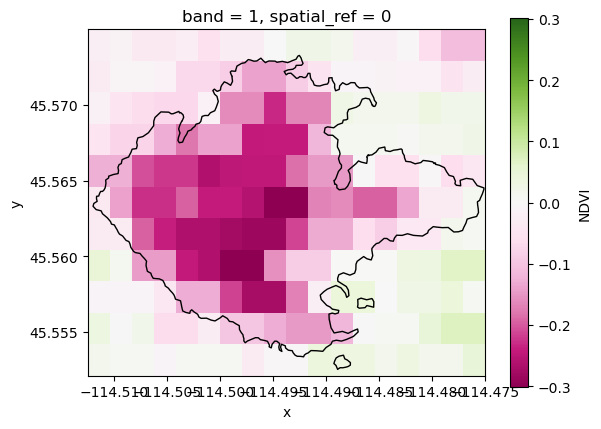

In [9]:
# Calculate the change in NDVI pre- and post- fire

import matplotlib.pyplot as plt

dndvi_da = (ndvi_ds
    .sel(date='2019')
    .mean('date')
    .NDVI
- ndvi_ds
    .sel(date='2017')
    .mean('date')
    .NDVI)

dndvi_da.plot(cmap=plt.colormaps['PiYG'])
reynolds_df.plot(facecolor='none', ax=plt.gca())

plt.show()

In [10]:
# Get the area outside the fire boundary

out_gdf = gpd.GeoDataFrame(geometry=reynolds_df.envelope).overlay(
    reynolds_df, how="difference"
)

In [11]:
ndvi_fire_ds = ndvi_ds.rio.clip(reynolds_df.geometry)
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)

In [12]:
ndvi_fire_df = (
    ndvi_fire_ds
    .groupby(ndvi_fire_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])
ndvi_out_df = (
    ndvi_out_ds
    .groupby(ndvi_out_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])

In [13]:
(ndvi_fire_df - ndvi_out_df).hvplot(
    xlabel=('Year'), ylabel='dNDVI',
    title='Difference in NDVI between inside and outside Reynolds Lake Fire boundary'
)

:Curve   [year]   (NDVI)

In [14]:
%%capture
%%bash
jupyter nbconvert reynoldslake-ndvi.ipynb --to html --no-input